In [105]:
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Phrases
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from itertools import combinations
import numpy as np
import platform
import matplotlib.font_manager as fm
import matplotlib as mpl
import fasttext
from konlpy.tag import Okt, Mecab
from wordcloud import WordCloud
from gensim.models import Word2Vec
import platform
import os
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import os
import json
from groq import Groq

In [133]:

nltk.download('punkt')

try:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('korean')) | {'때문', '이유', '말', '것', '등', '및', '수', '년', '월', '일', '때', '중', '한'}
except OSError:
    stop_words = set()

def set_font():
    if platform.system() == "Darwin": 
        font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
    elif platform.system() == "Windows":  
        font_path = "C:\\Windows\\Fonts\\malgun.ttf"
    else: 
        font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
    
    font_prop = fm.FontProperties(fname=font_path)
    mpl.rc('font', family=font_prop.get_name())
    mpl.rcParams['axes.unicode_minus'] = False 
    return font_prop

def preprocess_text(text):
    okt = Okt()
    sentences = nltk.sent_tokenize(text)
    processed_sentences = []

    for sentence in sentences:
        malist = okt.pos(sentence, norm=True, stem=True)
        # nouns = [word for word, pos in malist if pos == "Noun" and len(word) > 1 and word not in stop_words]
        # adjective = [word for word, pos in malist if pos == "Adjective" and len(word) > 1 and word not in stop_words]
        nouns_adjectives = [word for word, pos in malist 
                    if pos in ["Noun", "Adjective"] and len(word) > 1 and word not in stop_words]

        if nouns_adjectives:
            processed_sentences.append(nouns_adjectives)

    return processed_sentences

def extract_top_keywords_TF_IDF(text, num_keywords=10):
    processed_sentences = preprocess_text(text)

    tokens = [word for sentence in processed_sentences for word in sentence]

    if not tokens:
        tokens = ['기술', '주식', '경제'] 

    token_string = ' '.join(tokens)

    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform([token_string])
    scores = tfidf.idf_
    keyword_scores = list(zip(tfidf.get_feature_names_out(), scores))
    keyword_scores.sort(key=lambda x: x[1], reverse=True)

    top_keywords = [keyword for keyword, score in keyword_scores[:num_keywords]]
    return top_keywords



def build_relationship_graph_fasttext(model, keywords, additional_keywords=None,  threshold=0.5):
    if additional_keywords:
        keywords += additional_keywords
    keywords = list(set(keywords)) 
    
    G = nx.Graph()
    G.add_nodes_from(keywords)
    for combination in combinations(keywords, 2):
        vector1 = model.get_word_vector(combination[0])
        vector2 = model.get_word_vector(combination[1])
        if vector1 is not None and vector2 is not None:
            # Calculate cosine similarity
            similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
            if similarity >  threshold:  # Threshold for similarity
                G.add_edge(combination[0], combination[1], weight=similarity)
    
    return G


# def build_relationship_graph_word2vec(model, keywords, additional_keywords=None):
#     if additional_keywords:
#         keywords += additional_keywords
#     keywords = list(set(keywords)) 
    
#     G = nx.Graph()
#     G.add_nodes_from(keywords)
#     for combination in combinations(keywords, 2):
#         if combination[0] in model.wv and combination[1] in model.wv:
#             similarity = model.wv.similarity(combination[0], combination[1])
#             G.add_edge(*combination, weight=similarity)
    
#     return G


def build_relationship_graph_word2vec(model, keywords, additional_keywords=None, threshold=0.5):
    """
    Word2Vec 모델을 사용해 키워드 간의 관계 그래프를 생성합니다.

    Parameters:
    - model: Word2Vec 모델
    - keywords: 키워드 리스트
    - additional_keywords: 추가 키워드 리스트 (옵션)
    - threshold: 유사도 임계값 (기본값: 0.5)

    Returns:
    - NetworkX 그래프 (G)
    """
    if additional_keywords:
        keywords += additional_keywords
    keywords = list(set(keywords))  

    G = nx.Graph()
    G.add_nodes_from(keywords) 

    
    for combination in combinations(keywords, 2):
        if combination[0] in model.wv and combination[1] in model.wv:
            similarity = model.wv.similarity(combination[0], combination[1])
            if similarity >= threshold:  
                G.add_edge(*combination, weight=similarity)

    return G


def build_relationship_graph_mean(keywords, keyword_scores, additional_keywords=None):
    
    if additional_keywords:
        keywords += additional_keywords
    keywords = list(set(keywords)) 
    
    G = nx.Graph()
    
    G.add_nodes_from(keywords)
    for combination in combinations(keywords, 2):
        weight = np.mean([dict(keyword_scores).get(combination[0], 0), dict(keyword_scores).get(combination[1], 0)])
        G.add_edge(*combination, weight=weight)
    
    return G

def remove_particles(word):
    
    return re.sub(r'(은|는|이|가|을|를|에|의|와|과|도|로|으로|에서|에게|한테|께|까지|만|조차|마저|부터|밖에)$', '', word)

def remove_unwanted_verbs(word):
    
    return re.sub(r'(것|하다|되다|이다|있다|없다|같다|되다|보다|싶다|만들다|보다|주다|받다|오다|가다|나다|살다)$', '', word)

def extract_keywords(text, num_keywords=10):
    
    tokens = nltk.word_tokenize(text)
    
    keywords = [remove_unwanted_verbs(remove_particles(word)) for word in tokens if word.isalpha() and word not in stop_words]
    keywords = [word for word in keywords if word] 
    
    vectorizer = CountVectorizer()
    word_counts = vectorizer.fit_transform([' '.join(keywords)])
    tfidf = TfidfTransformer().fit_transform(word_counts)
    scores = tfidf.toarray()[0]
    
    keyword_scores = list(zip(vectorizer.get_feature_names_out(), scores))
    keyword_scores.sort(key=lambda x: x[1], reverse=True)
    top_keywords = [keyword for keyword, score in keyword_scores[:num_keywords]]
    
    return top_keywords, keyword_scores



def visualize_graph(G):
    font_prop = set_font()
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    edge_colors = [plt.cm.plasma(weight) for weight in weights]
    edge_widths = [weight * 2 for weight in weights]  # Scale edge widths based on similarity
    
    plt.figure(figsize=(8, 8))
    nx.draw_networkx(G, pos, with_labels=True, node_size=1500, node_color='skyblue', 
                     font_size=10, font_weight='bold', width=edge_widths, edge_color=edge_colors, 
                     edge_cmap=plt.cm.plasma, alpha=0.8, font_family=font_prop.get_name())
    plt.title("Keyword Relationship Graph", fontsize=16)
    plt.show()

def generate_wordcloud_from_article(comments):
    stopwords = {'것', '거', '게', '저', '나'}

    nouns = []
    mecab = Mecab()
    for comment in comments:
        if isinstance(comment, str):
            nouns.extend([noun for noun in mecab.nouns(comment) if noun not in stopwords])

    text = ' '.join(nouns)

    font_prop = set_font()
    font_path = font_prop.get_file()
    wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    # return nouns

def article_gubun(content):
    okt = Okt()
    # news = pd.read_excel(file_path)
    
    # content = articles

    word_dic = {}
    results = []

    for i in tqdm(range(len(content))):
        try:
            if isinstance(content[i], float):
                continue
            lines = str(content[i]).split('\n')
            for line in lines:
                malist = okt.pos(line, norm=True, stem=True)
                r = []
                for word in malist:
                    if word[1] == "Noun":
                        if not (word[0] in word_dic):
                            word_dic[word[0]] = 0
                        word_dic[word[0]] += 1

                    if not word[1] in ['Josa', 'Eomi', 'Punctuation'] and len(word[0]) > 1:
                        r.append(word[0])
                rl = (" ".join(r)).strip()
                results.append(rl)
        except Exception as e:
            print(f"Error processing content at index {i}: {e}")
            pass

    keys = sorted(word_dic.items(), key=lambda x: x[1], reverse=True)

    counted_noun = []
    for word, count in keys:
        if len(word) >= 2:
            counted_noun.append([word, count])

    return results



def split_sentences(article):
    """
    아티클을 마침표, 물음표, 느낌표를 기준으로 문장 단위로 분리합니다.
    """
    sentences = re.split(r'[.!?]', article)  # 문장 구분
    return [sentence.strip() for sentence in sentences if sentence.strip()]  # 공백 제거 후 반환

def tokenize_sentences(sentences):
    """
    각 문장을 형태소 분석하고 명사와 형용사만 추출합니다.
    """
    okt = Okt()
    tokenized_sentences = []

    for sentence in sentences:
        tokens = [word for word, pos in okt.pos(sentence, norm=True, stem=True)
                  if pos in ["Noun", "Adjective"] and len(word) > 1]  # 명사와 형용사만
        if tokens:
            tokenized_sentences.append(tokens)  # 비어있지 않은 경우만 추가

    return tokenized_sentences

def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    """
    주어진 문장 리스트를 이용해 Word2Vec 모델을 학습합니다.
    """
    tokenized_sentences = tokenize_sentences(sentences)

    if not tokenized_sentences:
        raise ValueError("토큰화된 문장이 없습니다. 데이터를 확인해주세요.")

    model = Word2Vec(sentences=tokenized_sentences,
                     vector_size=vector_size,
                     window=window,
                     min_count=min_count,
                     workers=workers)
    print("Word2Vec 모델 학습이 완료되었습니다.")
    return model


def find_similar_words(model, positive_words, topn=10):
    similar_words = model.wv.most_similar(positive=positive_words, topn=topn)
    return similar_words



def llm_keyword(GROQ_API_KEY, articles):
    
    client = Groq(api_key=GROQ_API_KEY)
    article = ' '.join(articles)
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """you are a helpful assistant to return core 10 keywords of the article with the same language of the article. 
                                do not return any other except keyword. return by json.
                                Return example 
                                {'keywords': ['word', 'word', 'word', 'word', 'word', 'word', 'word', 'word']}"""
            },
            {
                "role": "user",
                "content": article,
            }
        ],
        model="llama-3.1-70b-versatile",
        response_format = { "type": "json_object" }, 
    )

    llm_response = chat_completion.choices[0].message.content.strip()

    try:
        response_dict = json.loads(llm_response)
        keywords = response_dict.get("keywords", [])
        return keywords
    except json.JSONDecodeError:
        return llm_response

def word_vector_fasttext_process(article, keywords=None, additional_keywords=None, threshold=0.2):
    set_font()
    model = fasttext.load_model("model/facebook_ko.bin")
    combined_text = ' '.join(article)
    if keywords == None:
        keywords = extract_top_keywords_TF_IDF(combined_text)  # Extract top keywords using TF-IDF
    
    G = build_relationship_graph_fasttext(model, keywords, additional_keywords,  threshold)
    visualize_graph(G)

def word_vector_word2vec_process(articles, keywords=None, additional_keywords=None,  threshold=0.1):
    set_font()
    # gubun = article_gubun(article)
    article = ' '.join(articles)
    sentences = split_sentences(article)  # 문장 분리
    model = train_word2vec_model(sentences)  # Word2Vec 학습
    combined_text = ' '.join(articles)
    if keywords == None:
        keywords = extract_top_keywords_TF_IDF(combined_text) # Extract top keywords using TF-IDF
    G = build_relationship_graph_word2vec(model, keywords, additional_keywords,  threshold)
    visualize_graph(G)


def word_vector_textscore_process(article, keywords=None, additional_keywords=None):
    set_font()  
    combined_text = ' '.join(article)
    keywords_tf, keyword_scores = extract_keywords(combined_text) # Extract top keywords and score using TF-IDF
    
    if keywords == None:
        keywords = keywords_tf

    G = build_relationship_graph_mean(keywords, keyword_scores, additional_keywords)
    visualize_graph(G)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathanoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathanoh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [125]:
article = """기술주를 중심으로 미국 뉴욕증시가 지지부진한 흐름을 나타내고 있다. ‘인공지능(AI) 거품론’ ‘반도체 고점론’ 등 비관론이 퍼지면서 전체 증시가 한 차례 출렁인 가운데 11월 대선, 연방준비제도(연준)의 금리인하 속도 등 불확실한 요인들이 하방 압력을 가하고 있기 때문이다. 장우석 유에스스탁 부사장은 10월 8일 인터뷰에서 “이럴 때 엔비디아를 사 모아야 한다”고 말했다. 최근 서학개미는 기존에 선호하던 기술주를 대거 처분하고 배당주, 현금 등 안전자산 쪽으로 투자 노선을 갈아탄 상태인데, 이에 대해 “지금은 떠날 타이밍이 아니다”라고 조언한 것이다. 다음은 장 부사장과 나눈 일문일답.
“美 경기침체, 처음부터 없었다”
11월 대선까지는 증시가 횡보할 것이라는 전망이 많은데.
‌
“원래 대선 직전에는 증시가 재미없다. 한 달간 옆으로 긴 장이 이어지다가 선거가 끝난 뒤부터 오를 것이다. 또 지금은 누가 대통령이 되느냐보다 금리가 얼마나 떨어질지가 더 관건이라서 11월 5일(현지 시간) 대선이 끝나더라도 경우에 따라 그 직후 상승세가 강하지 않을 수 있다.”
‌
고용지표 강세로 11월 연준이 금리를 동결할 수 있다는 분석도 일각에서 나오는데.
‌
“9월 고용지표가 예상을 뛰어넘으면서 ‘금리인하를 괜히 한 것 아니냐’는 반응이 나오고 있다. 다만 개인적으로는 2022년 6월 9.1% 상승률을 보인 소비자물가지수(CPI)가 지금 2.5%까지 내려왔기 때문에 인하는 당연한 수순 아닌가 싶다. 이번 주 발표 예정인 9월 CPI가 전망치(2.3%)에서 크게 어긋나지만 않으면 아마 0.25%p 인하는 할 거라고 본다. 아직까지 동결 전망은 소수다.”
‌
이번 고용지표로 경기침체 우려는 어느 정도 불식됐다고 보면 되나.
‌
“침체는 없다. 분기 국내총생산(GDP) 성장률이 3%대인 국가에 침체는 애초에 어울리지 않는 얘기다. 7월 미국 공급관리협회(ISM) 제조업지수가 큰 폭으로 떨어지면서 갑자기 위기감이 고조됐던 것인데, 지금은 흔적도 없이 사라져가고 있다. 어제도 글로벌 투자은행(IB) 골드만삭스가 미국 경기침체 확률을 15%로 낮춰 잡았다. 15%면 ‘없다’는 뜻으로 봐도 무방하다.”
"""




articles = []
articles.append(article)

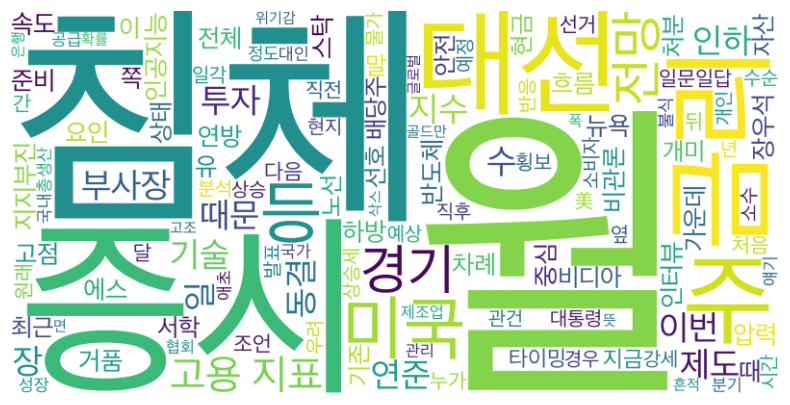

In [96]:
generate_wordcloud_from_article(articles)

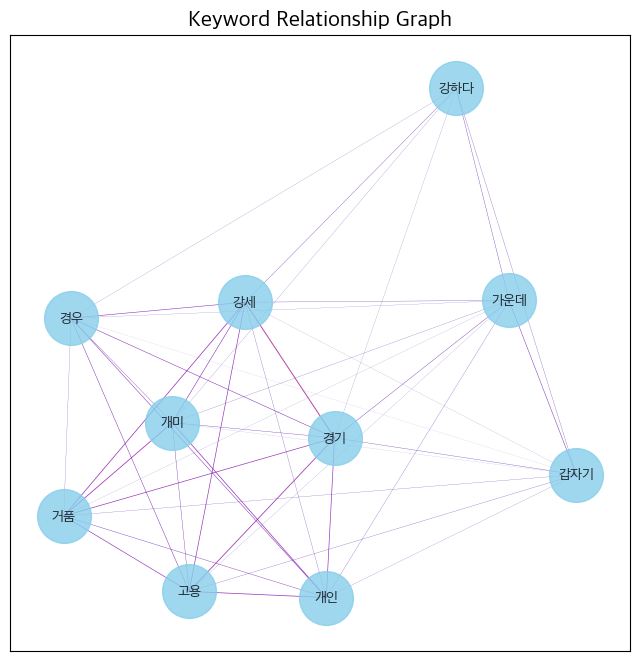

In [126]:
#facebook vector 모델

word_vector_fasttext_process(articles, additional_keywords=[],  threshold=0.02) 

Word2Vec 모델 학습이 완료되었습니다.


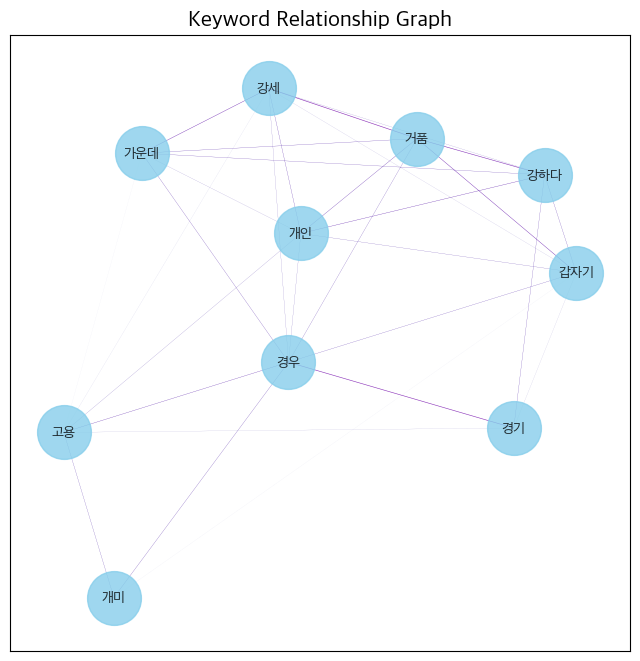

In [127]:
#article 로 vector 만들어서 해보기

word_vector_word2vec_process(articles,  threshold=0.002)

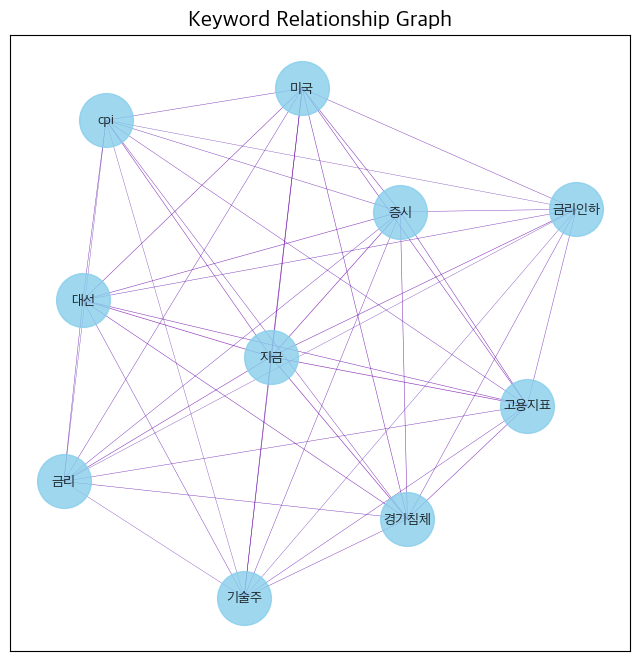

In [135]:
word_vector_textscore_process(articles)

In [122]:
#https://console.groq.com/keys 가서 받아서 넣음 되요. 공짜임


GROQ_API_KEY = ''
keywords = llm_keyword(GROQ_API_KEY=GROQ_API_KEY, articles=articles)
print(keywords)

['증시', '기술주', '엔비디아', '대선', '금리인하', '고용지표', '경기침체', '금리', 'CPI', '상승률']


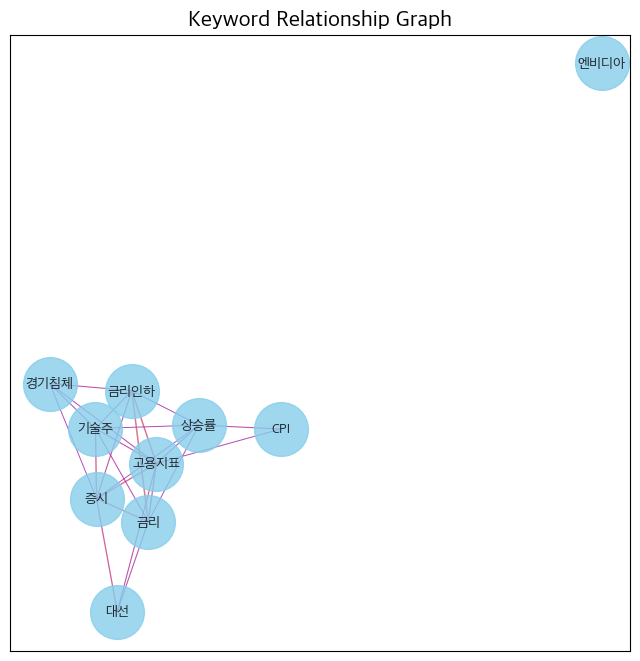

Word2Vec 모델 학습이 완료되었습니다.


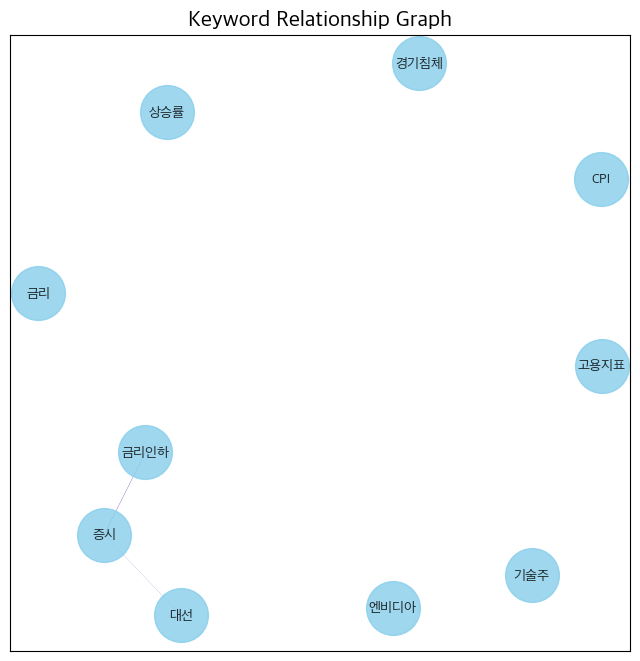

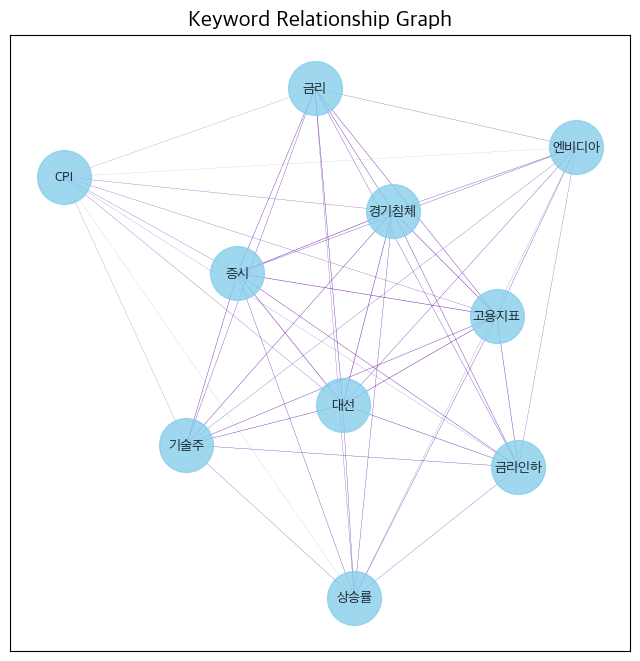

In [137]:
word_vector_fasttext_process(articles, keywords, threshold=0.3)
word_vector_word2vec_process(articles,  keywords, threshold=0.02)
word_vector_textscore_process(articles, keywords)
